<a href="https://colab.research.google.com/github/starkjiang/TrAC-Interpretability/blob/main/module3_iia_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-hoc Analysis for Model Interpretability

In this tutorial, we are going to see a couple methods that have been used to interpret the model prediction results, including permutation feature importance and partial dependence plot. We still use shallow machine learning models as examples. We adapted several examples from Scikit-Learn, including the [Partial Dependence Plot and Individual Conditional Expectation](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html) and [Permuation Feature Importance](https://scikit-learn.org/stable/modules/permutation_importance.html).

# 1. Permutation Feature Importance

Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model's statistical performance on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model's score. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product

from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_diabetes, fetch_openml
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    RandomForestClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.inspection import (
    PartialDependenceDisplay,
    permutation_importance
)
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    QuantileTransformer,
)

from time import time


diabetes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(
    diabetes.data,
    diabetes.target,
    random_state=0
)
model = Ridge(alpha=1e-2).fit(X=X_train, y=y_train)
model.score(X=X_val, y=y_val)

0.356667532293942

In [ ]:
r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{diabetes.feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

s5      0.204 +/- 0.050
bmi     0.176 +/- 0.048
bp      0.088 +/- 0.033
sex     0.056 +/- 0.023


Note that the importance values for the top features represent a large fraction of the reference score of 0.356.

Permutation importances can be computed either on the training set or on a held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

The permutation feature importance depends on the score function that is specified with the scoring argument. This argument accepts multiple scorers, which is more computationally efficient than sequentially calling permutation_importance several times with a different scorer, as it reuses model predictions.

In [ ]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    model,
    X_val,
    y_val,
    scoring=scoring,
    n_repeats=30,
    random_state=0
)

for metric in r_multi:
    print(f"{metric}:")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {diabetes.feature_names[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")


r2:
    s5      0.204 +/- 0.050
    bmi     0.176 +/- 0.048
    bp      0.088 +/- 0.033
    sex     0.056 +/- 0.023
neg_mean_absolute_percentage_error:
    s5      0.081 +/- 0.020
    bmi     0.064 +/- 0.015
    bp      0.029 +/- 0.010
neg_mean_squared_error:
    s5      1013.866 +/- 246.445
    bmi     872.726 +/- 240.298
    bp      438.663 +/- 163.022
    sex     277.376 +/- 115.123


The ranking of the features is approximately the same for different metrics even if the scales of the importance values are very different. However, this is not guaranteed and different metrics might lead to significantly different feature importances, in particular for models trained for imbalanced classification problems, for which the choice of the classification metric can be critical.

# Permutation Importance Algorithm

1. Inputs: fitted predictive model $m$, tablular dataset (training or validation) $D$.
2. Compute the reference score $s$ of the mdoel $m$ on data $D$ (for instance the accuracy for a classifier or the $R^2$ for a regressor).
3. For each feature $j$ (column of $D$):
    1. for each repetition $k$ in $1,...,K$:
        1. Randomly shuffle column $j$ of dataset $D$ to generate a corrupated version of the data named $\tilde{D}_{k,j}$.
        2. Compute the score $s_{k,j}$ of model $m$ on corrupted data $\tilde{D}_{k,j}$.
    2. Compute importance $i_j$ for feature $f_j$ defined as:
        $i_j = s-\frac{1}{K}\sum_{k=1}^Ks_{k,j}$

# Comparison between Permutation Importance and Random Forest Feature Importance



In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=42
)

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


In [ ]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

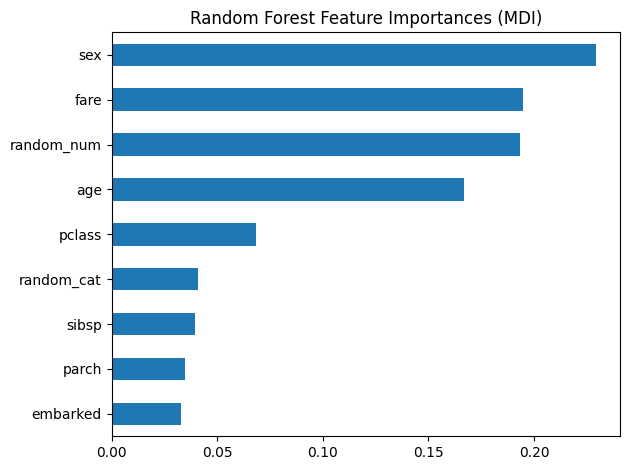

In [ ]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

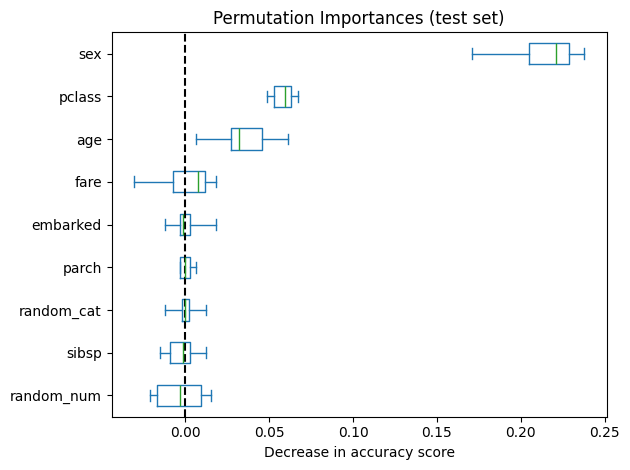

In [ ]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


Compute the permutation importances on the training set.

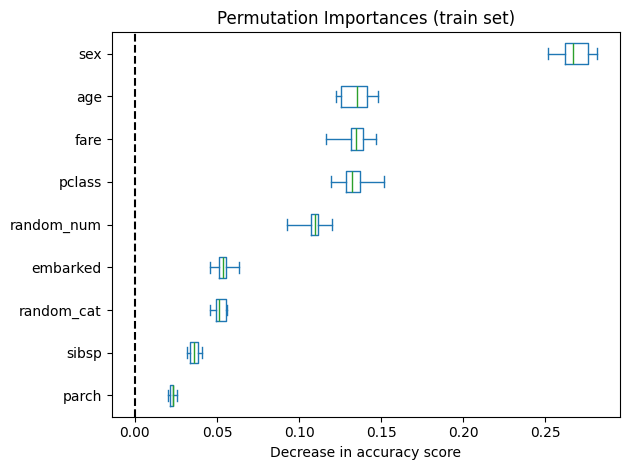

In [ ]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# 2. Partial Dependence and Individual Conditional Expectation Plots

Partial dependence plots (PDP) and individual conditional expectation (ICE) plots can be used to visualize and analyze interaction between the target response and a set of input features of interest.

They both assume that the input features of interest are independent from the complement features, and this assumption is often violated in practice. Thus, you may want to pay attention to the feature correlations when analyzing them.

# 2.1. Patial Dependence Plot

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

In [ ]:
bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

# We use only a subset of the data to speed up the example.
X = X.iloc[::5, :]
y = y[::5]

X["weather"].value_counts()

,count
weather,
clear,2284
misty,904
rain,287
heavy_rain,1


In [ ]:
X["weather"] = (
    X["weather"]
    .astype(object)
    .replace(to_replace="heavy_rain", value="rain")
    .astype("category")
)
X["year"].value_counts()

,count
year,
1,1747
0,1729


In [ ]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1729 entries, 0 to 8640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      1729 non-null   category
 1   month       1729 non-null   int64   
 2   hour        1729 non-null   int64   
 3   holiday     1729 non-null   category
 4   weekday     1729 non-null   int64   
 5   workingday  1729 non-null   category
 6   weather     1729 non-null   category
 7   temp        1729 non-null   float64 
 8   feel_temp   1729 non-null   float64 
 9   humidity    1729 non-null   float64 
 10  windspeed   1729 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 115.4 KB


In [ ]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

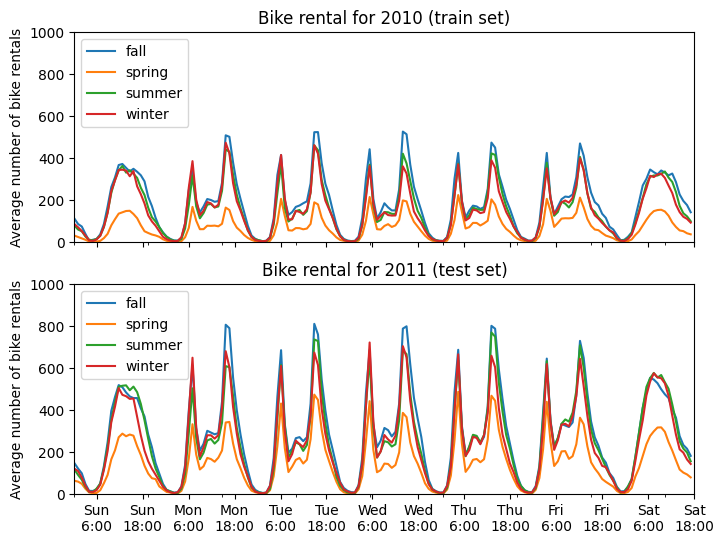

In [ ]:
days = ("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bikes.frame.groupby(
    ["year", "season", "weekday", "hour"], observed=True
).mean(numeric_only=True)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season", observed=True).plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        )
    )
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

In [ ]:
mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
mlp_preprocessor

ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])

In [ ]:
hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

We first train MLP on the dataset and check the PDP.

In [ ]:
print("Training MLPRegressor...")
tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 1.297s
Test R2 score: 0.61


Computing partial dependence plots...
done in 4.142s


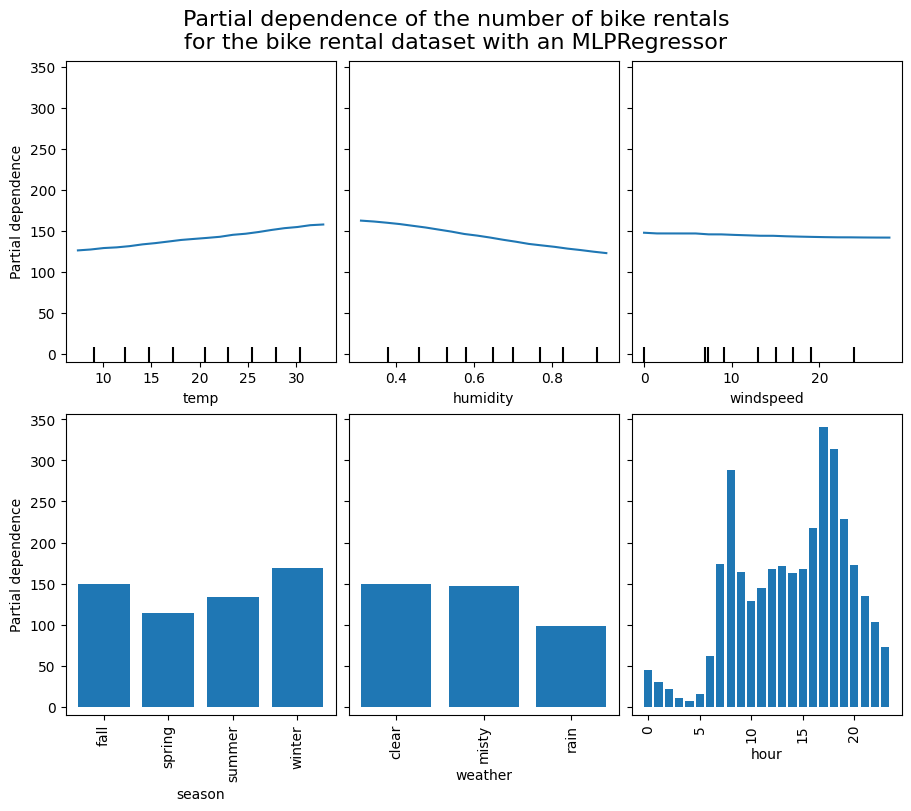

In [ ]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with an MLPRegressor"
    ),
    fontsize=16,
)

We then move to the Gradient Boosting model.

In [ ]:
print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.278s
Test R2 score: 0.62


Computing partial dependence plots...
done in 2.777s


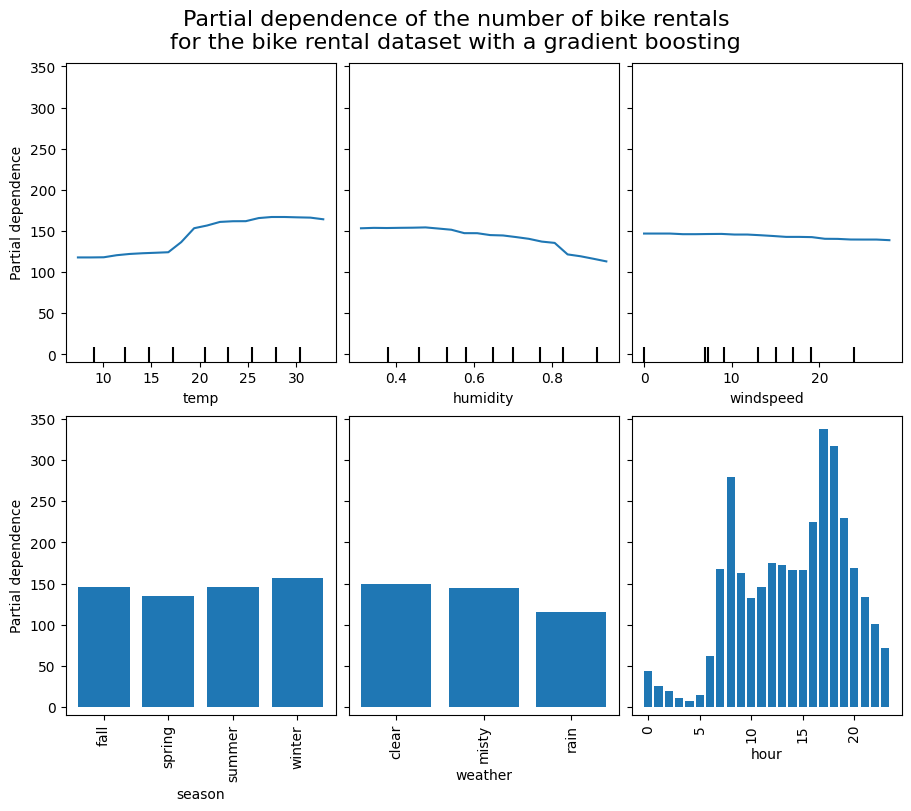

In [ ]:
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with a gradient boosting"
    ),
    fontsize=16,
)

# 2.2. Individual Effect Plot

PDP is an average of the marginal effects of the features. We are averaging the response of all samples of the provided set. Thus, some effects could be hidden. In this regard, it is possible to plot each individual response. This representation is called the Individual Conditional Expectation (ICE) plot. In the plot below, we plot 50 randomly selected ICEs for the temperature and humidity features.

Computing partial dependence plots and individual conditional expectation...
done in 0.961s


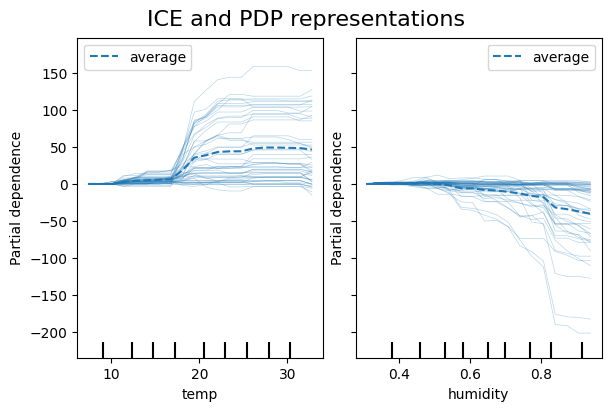

In [ ]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(
    ncols=2,
    figsize=(6, 4),
    sharey=True,
    constrained_layout=True
)

features_info = {
    "features": ["temp", "humidity"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

Computing partial dependence plots...
done in 14.132s


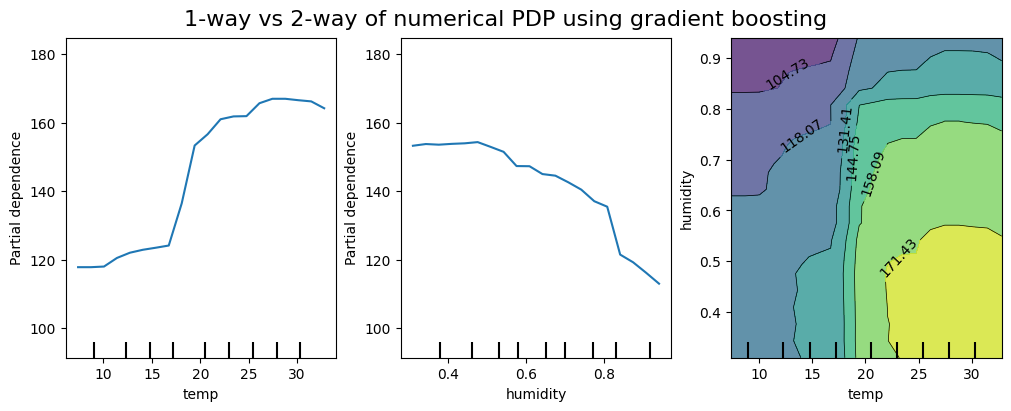

In [ ]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)
